In [1]:
#!/usr/bin/env python

# NMME_WTing_skill.ipynb

In [1]:
'''
    File name: NMME_WTing_skill.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.03.2021
    Date last modified: 04.03.2021

    ##############################################################
    Dependencies:
    This program requires data from running:
    projects/Arizona_WTing/programs/NMME_WTing/NMME_WTing.ipynb
    
    Purpos:

    1) Read the preprocessed WT data

    2) Detrend and normalize the data

    3) Calculate correlation coefficients for each model, start month, and basin

    4) Plot them in one heat map per basin

'''

'\n    File name: NMME_WTing_skill.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 04.03.2021\n    Date last modified: 04.03.2021\n\n    ##############################################################\n    Dependencies:\n    This program requires data from running:\n    projects/Arizona_WTing/programs/NMME_WTing/NMME_WTing.ipynb\n    \n    Purpos:\n\n    1) Read the preprocessed WT data\n\n    2) Detrend and normalize the data\n\n    3) Calculate correlation coefficients for each model, start month, and basin\n\n    4) Plot them in one heat map per basin\n\n'

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import scipy.ndimage
import matplotlib.path as mplPath
from scipy.interpolate import interp1d
import time
from math import atan2, degrees, pi
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import csv
import pygrib
from scipy import interpolate
from scipy import signal
# from netcdftime import utime
from scipy.ndimage import gaussian_filter
import scipy.ndimage.filters as filters


#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [3]:
########################################
#                            USER INPUT SECTION

DataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/'
SRegionsAll = ['1501', '1502', 'HUC6-00', 'HUC6-03']
SRegionNames = ['AZ-West', 'AZ-East', 'NM-North', 'NM-South']
PRfile_basin = ['/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_1501_1982-2018_6-7-8-9-10.npz',
               '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_1502_1982-2018_6-7-8-9-10.npz',
               '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_HUC6-00_1982-2018_6-7-8-9-10.npz',
               '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_HUC6-03_1982-2018_6-7-8-9-10.npz']
sPlotFile = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/'
# center/model name, ensemble members, file convention
NMME_models = ['NCAR-CESM1','NASA-GMAO-GEOS-5','UM-RSMAS-CCSM4','CCCMA-CanCM4','IFS']
ModelColors = ['#1f78b4','#e31a1c','#ff7f00','#33a02c','#fb9a99']

# for each variable we have the general varname, the netCDF var name, and the pressure level (-1 means 2D field), netCDF varname
rgsWTvars = ['Q850']
WTVars=('-').join(rgsWTvars)

MONTHS=[6,7,8,9,10]
StartMonths=[2,3,4,5,6,7,8]
rgsStartMonths=['Feb','Mar','Apr','May','Jun','Jul','Aug']
WTsort = [[0,2,1],[1,2,0],[1,2,0],[0,1,2]]

dStartDay=datetime.datetime(int(1982), 1, 1,0)
dStopDay=datetime.datetime(int(2010), 12, 31,0)
rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d')
rgdTimeMM = pd.date_range(dStartDay, end=dStopDay, freq='m')
rgiYY=np.unique(rgdTimeDD.year)
rgdTimeDD = rgdTimeDD[np.isin(rgdTimeDD.month, MONTHS)]
rgdTimeMM = rgdTimeMM[np.isin(rgdTimeMM.month, MONTHS)]

YYYY_ERA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/NCAR-CESM1_Q850_1982-2010_NM-North_ForecastMonths-2-3-4-5-6_MonsoonMonths-6-7-8-9-10.npz')['YYYY_ERA']
ERA_selYears = np.isin(YYYY_ERA, rgiYY)
TimeMonsSeason = pd.to_datetime(np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/NCAR-CESM1_Q850_1982-2010_NM-North_ForecastMonths-2-3-4-5-6_MonsoonMonths-6-7-8-9-10.npz')['TimeMonsSeason'])

### Load the preprocessed WT data

In [4]:
PredMonths = '-'.join(np.array(MONTHS).astype('str'))
sStartMonths = '-'.join(np.array(StartMonths).astype('str'))

ERA_WTs = np.zeros((len(TimeMonsSeason), len(rgiYY), len(StartMonths), len(SRegionNames))); ERA_WTs[:] = np.nan
NAAM_WTs = np.zeros((len(TimeMonsSeason), len(rgiYY), len(NMME_models), len(SRegionNames), len(StartMonths), 25)); NAAM_WTs[:] = np.nan
EAR_Predictors = np.zeros((len(rgiYY),len(TimeMonsSeason), len(StartMonths), len(SRegionNames), len(rgsWTvars))); EAR_Predictors[:] = np.nan
NAAM_Predictors = np.zeros((len(rgiYY),len(TimeMonsSeason), len(StartMonths), len(SRegionNames), len(StartMonths), len(rgsWTvars), 25)); NAAM_Predictors[:] = np.nan
for mo in range(len(NMME_models)):
    for re in range(len(SRegionNames)):
        if NMME_models[mo] != 'IFS':
            DATAfile = DataDir+NMME_models[mo]+'_'+WTVars+'_'+str(rgiYY[0])+'-'+str(rgiYY[-1])+'_'+SRegionNames[re]+'_ForecastMonths-'+sStartMonths+'_MonsoonMonths-'+PredMonths+'.npz'
            DATA = np.load(DATAfile)
            ERA_WTs[:,:,mo,re] = DATA['ERA_WTfin'][ERA_selYears,:].T
            EAR_Predictors[:,:,mo,re] = np.mean(DATA['ERA_predictors'][ERA_selYears,:], axis=(2,3))
            # --
            NAAM_WTs[:,:,mo,re,:,:10] = DATA['WT_NMME']
            NAAM_Predictors[:,:,mo,re,:][:,:,:,:,:10] = np.moveaxis(np.mean(DATA['NMMEpredictors'], axis=(3,4)), 1,0)
        else:
            try:
                DATAfile = DataDir+NMME_models[mo]+'_'+WTVars+'_1982-'+str(rgiYY[-1])+'_'+SRegionNames[re]+'_ForecastMonths-2-3-4-5-6-7-8_MonsoonMonths-'+PredMonths+'.npz'
                DATA = np.load(DATAfile)
                Y_IFS = np.isin(rgiYY,DATA['YYYYY_NMME'])
                M_IFS = np.isin(StartMonths,DATA['StartMonths'])
                ERA_WTs[:,:,mo,re] = DATA['ERA_WTfin'][ERA_selYears,:].T
                NAAM_WTs[:,Y_IFS,mo,re,-np.sum(M_IFS):,:] = DATA['WT_NMME']
                NAAM_Predictors[Y_IFS,:,mo,re,-np.sum(M_IFS):,:,:] = np.moveaxis(np.mean(DATA['NMMEpredictors'], axis=(3,4)), 1,0)
            except:
                print('    Not found: '+DATAfile)

### Save WT data for Erin

In [5]:
# Save one csv file for each year, forecast month, and region
SHAPE = NAAM_WTs.shape
EnsMemb = [10,10,10,10,25]
SaveDir = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/WTs/'
for yy in range(SHAPE[1]):
    TIME_act = pd.date_range(datetime.datetime(rgiYY[yy], 6, 1,0), end=datetime.datetime(rgiYY[yy], 10, 31,0), freq='d')
    for mm in range(SHAPE[4]):
        for re in range(SHAPE[3]):
            df = pd.DataFrame({})
            
            YYYY = str(rgiYY[yy])
            MM = str(StartMonths[mm]).zfill(2)
            RE = SRegionNames[re]
            FileName = YYYY+'-'+MM+'_'+RE+'_Monsoon-WTs.csv'
            
            df['date'] = TIME_act
            # add ERA5 WTS
            DATA = ERA_WTs[:,yy,mm,re].astype(int)
            DATA_FIN = np.copy(DATA); DATA_FIN[:] = 0
            for wt in range(3):
                DATA_FIN[DATA == WTsort[re][wt]] = wt
            df['ERA5'] = DATA_FIN
            for mo in range(SHAPE[2]):
                MOD = NMME_models[mo]
                for em in range(EnsMemb[mo]):
                    NAME = MOD+'_'+str(em+1)
                    DATA = NAAM_WTs[:,yy,mo,re,mm,em].astype(int)
                    DATA_FIN = np.copy(DATA); DATA_FIN[:] = 0
                    for wt in range(3):
                        DATA_FIN[DATA == WTsort[re][wt]] = wt
                    DATA_FIN[DATA < 0] = -999
                    df[NAME] = DATA_FIN
            df.to_csv(SaveDir+FileName ,index=False)

### Load the precipitation time series in each catchment

In [6]:
# from scipy import signal
# PR_basins = np.zeros((NAAM_WTs.shape[1], NAAM_WTs.shape[0], len(SRegionNames))); PR_basins[:]=np.nan
# for ba in range(len(SRegionNames)): 
#     DATA = np.load(PRfile_basin[ba])
#     PRtmp = DATA['rgrPRrecords']
#     PR_basins[:,:,ba] = np.reshape(PRtmp, (int(PRtmp.shape[0]/NAAM_WTs.shape[0]),NAAM_WTs.shape[0]))[ERA_selYears,:]
    
# load the combined HUC6 basin precipitation (is highly correlated with the original data)
# Data comes from - ~/projects/Arizona_WTing/programs/NMME_PR_prediction/NMME_PR_prediction.ipynb
DATA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/PR/PRISM_PR-observations_Monsoon-Basins.npz')
PR_basins = DATA['precipitation']

# PR_YYYY_detrend = signal.detrend(PR_basins[:,:], axis=0)

# Save precipitation for Erin

In [7]:
FileName = 'Basin_average_precipitaiton.csv'
PR_DATA = np.reshape(PR_basins, (PR_basins.shape[0]*PR_basins.shape[1], PR_basins.shape[2]))
df = pd.DataFrame({})
df['date'] = rgdTimeMM
for re in range(len(SRegionNames)):
    df[SRegionNames[re]] = PR_DATA[:,re]
    
df.to_csv(FileName ,index=False)

### Plot the seasonal cycle of WT evolution

(153, 29, 5, 7, 25)

        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/NMME_WT-seasonal-cycle.pdf


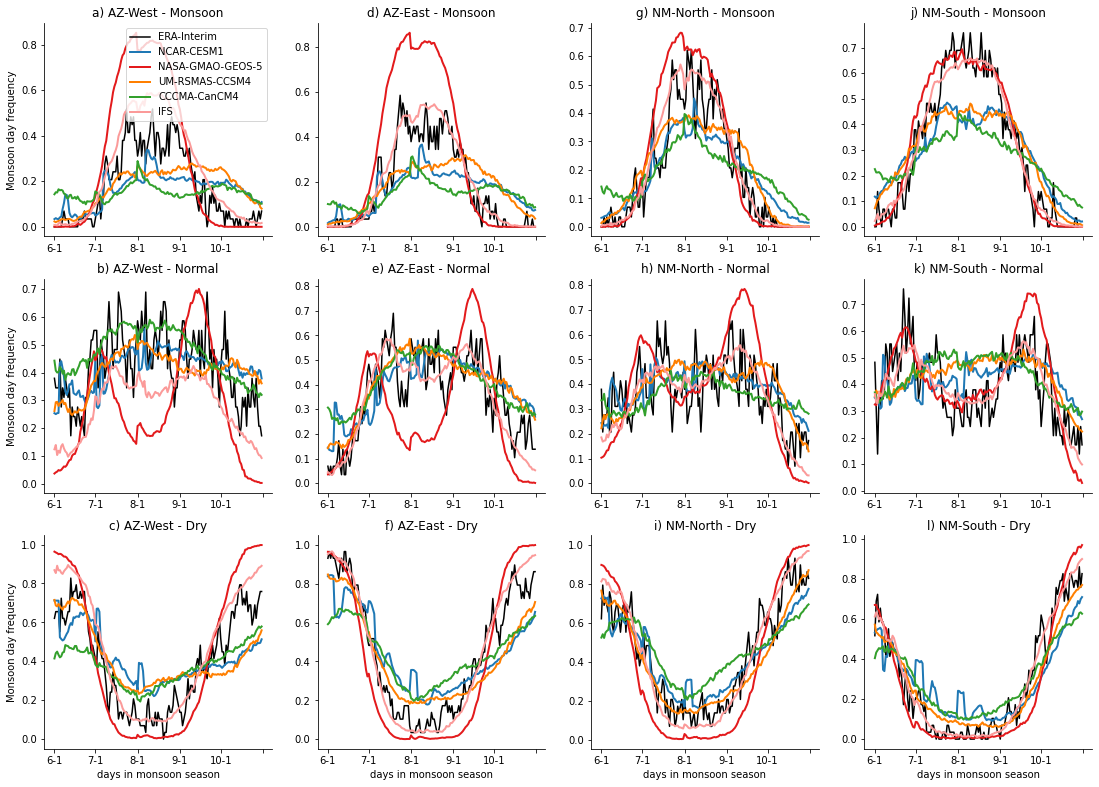

In [14]:
# lt=3

fig = plt.figure(figsize=(16,12))
rgsLableABC=list(string.ascii_lowercase)
# Histogram plots
gs1 = gridspec.GridSpec(3,4) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.20, hspace=0.20)
WTname = ['Monsoon','Normal','Dry']
for ba in range(len(SRegionNames)): 
    for wt in range(3):
        ax = plt.subplot(gs1[wt,ba])
        plt.title(rgsLableABC[ba*3+wt]+') '+SRegionNames[ba]+' - '+WTname[wt])
        ERA_WT = np.mean(ERA_WTs[:,:,0,ba] == WTsort[ba][wt], axis=1)
        iWTfr = np.array(NAAM_WTs[:,:,:,ba,:,:] == WTsort[ba][wt])*1.
        iWTfr[np.isnan(NAAM_WTs[:,:,:,ba,:,:])] = np.nan
        NAMM_WTact = np.nanmean(iWTfr, axis=(1,3,4))
        plt.plot(TimeMonsSeason.month.astype('str')+"-"+TimeMonsSeason.day.astype('str'), ERA_WT, c='k', label='ERA-Interim')
        for mo in range(len(NMME_models)):
            plt.plot(TimeMonsSeason.month.astype('str')+"-"+TimeMonsSeason.day.astype('str'), NAMM_WTact[:,mo], color=ModelColors[mo], label=NMME_models[mo], lw=2)
        if ba == 0:
            plt.ylabel('Monsoon day frequency')
        if wt == 2:
            plt.xlabel('days in monsoon season')
        plt.xticks([0,30,61,92,122,153])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if (wt == 0) & (ba == 0):
            plt.legend()
            
            
sPlotName= 'NMME_WT-seasonal-cycle.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### Calcualte Correlations between NAAM models and ERA-Interim

In [9]:
ERA_WTs.shape

(153, 29, 7, 4)

In [10]:
import seaborn as sns
from scipy import signal
Norma_WT_frequ = np.zeros((2,len(rgiYY),len(StartMonths)+1,len(NMME_models),len(SRegionNames),3)); Norma_WT_frequ[:]=np.nan

# calculate correlation coefficiants
SpearmanR = np.zeros((2,len(StartMonths),len(NMME_models),len(SRegionNames),3)); SpearmanR[:]=np.nan
PearsonR = np.copy(SpearmanR)
for ba in range(len(SRegionNames)): 
    for wt in range(3):
        for mod in range(len(NMME_models)):
            for mon in range(NAAM_WTs.shape[4]):
                MODEL = NAAM_WTs[:,:,mod,ba,mon,:] == WTsort[ba][wt]
                OBS = ERA_WTs[:,:,0,ba] == WTsort[ba][wt]
                FIN_DD = ~np.isnan(NAAM_WTs[:,-1,mod,ba,mon,0])
                MODEL = np.nanmean(MODEL, axis=2)
                FIN_YY = ~np.isnan(np.nanmean(MODEL[:,:],axis=0))
                if (np.sum(FIN_DD) > 0) & (np.sum(FIN_YY) > 0):
                    # calculate seasonal averages
                    MODEL = np.mean(MODEL[FIN_DD,:], axis=0)
                    OBS = np.mean(OBS[FIN_DD,:], axis=0)
                    # Detrend the data
                    MODEL_DT = signal.detrend(MODEL[FIN_YY])
                    OBS_DT = signal.detrend(OBS[FIN_YY])
                    SpearmanR[:,mon,mod,ba,wt] = scipy.stats.spearmanr(MODEL_DT,OBS_DT)
                    PearsonR[:,mon,mod,ba,wt] = scipy.stats.pearsonr(MODEL_DT,OBS_DT)
                    
                    # save the data for further analysis
                    Norma_WT_frequ[0,FIN_YY,mon,mod,ba,wt] = OBS_DT
                    Norma_WT_frequ[1,FIN_YY,mon,mod,ba,wt] = MODEL_DT

### plot heatmaps showing correlation coefficients for each basin

        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/NMME_hindcast_annomaly-corrections_WT-Monsoon.pdf


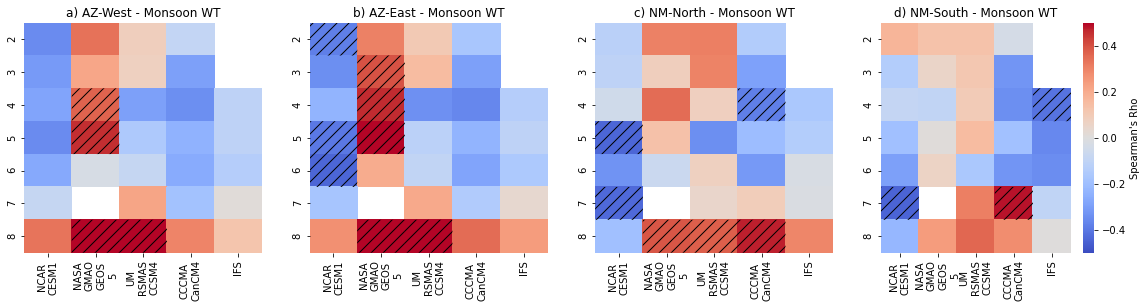

In [11]:
wt=0

fig = plt.figure(figsize=(16,4.5))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.03, right=0.98,
           bottom=0.20, top=0.91,
           wspace=0.20, hspace=0.20)
NMME_modelsBreak = [NMME_models[ii].replace('-','\n') for ii in range(len(NMME_models))]

for ba in range(len(SRegionNames)):
    ax = plt.subplot(gs1[0,ba])
    plt.title(rgsLableABC[ba]+') '+SRegionNames[ba]+' - '+WTname[wt]+' WT')
    if ba == 3:
        sns.heatmap(SpearmanR[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, 
                             cbar_kws={'label': "Spearman's Rho"})
    else:
        sns.heatmap(SpearmanR[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar=False)
    # Show significance
    x= np.arange(len(NMME_modelsBreak)+1)
    y= np.arange(len(StartMonths)+1)
    zm = np.ma.masked_greater(SpearmanR[1,:,:,ba,wt], 0.05)
    plt.pcolor(x, y, zm, hatch='//', alpha=0.)
    
    
    ax.set_yticklabels(StartMonths)
    ax.set_xticklabels(NMME_modelsBreak, rotation = 90)
    
sPlotName= 'NMME_hindcast_annomaly-corrections_WT-'+WTname[wt]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

# Calculate Correlation between forecasted WT frequency and oberved seasonal precipitation

In [12]:
import seaborn as sns
from scipy import signal

Seasons =[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True], 
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True], # full season
          [True, True, True, False, False],
          [True, True, True, False, False],
          [True, True, True, False, False], # early season
          [False, False, False, True, True],
          [False, False, False, True, True], # late season
          [True, False, False, False, False], # June
          [False, True, False, False, False], # July
          [False, False, True, False, False], # August
          [False, False, False, True, False], # September
          [False, False, False, False, True]] # October

# calculate correlation coefficiants
SpearmanR_PR = np.zeros((2,len(StartMonths),len(NMME_models),len(SRegionNames),3,len(Seasons))); SpearmanR_PR[:]=np.nan
PearsonR_PR = np.copy(SpearmanR_PR)
Norma_WT_frequ_PR = np.zeros((2,len(rgiYY),len(StartMonths)+1,len(NMME_models),len(SRegionNames),3,len(Seasons))); Norma_WT_frequ_PR[:]=np.nan

for ba in range(len(SRegionNames)): 
    for wt in range(3):
        for mod in range(len(NMME_models)):
            for mon in range(NAAM_WTs.shape[4]):
                for se in range(len(Seasons)):
                    MODEL = (NAAM_WTs[:,:,mod,ba,mon,:] == WTsort[ba][wt])*1.
                    MODEL[np.isnan(NAAM_WTs[:,-1,mod,ba,mon,0]),:,:] = np.nan
                    OBS = PR_basins[:,:,ba].T
                    # Calculate monthly averages for WTs
                    MODEL_MON = np.array([np.sum(MODEL[TimeMonsSeason.month == ii,:,:],axis=0) for ii in MONTHS])
                    MODEL_MON = np.mean(MODEL_MON, axis=2)
                    FIN_MM = Seasons[se] * ~np.isnan(MODEL_MON[:,-1])
                    FIN_YY = ~np.isnan(NAAM_WTs[-1,:,mod,ba,mon,0])* ([False]*11+[True]*18)
                    if (np.sum(FIN_MM) > 0) & (np.sum(FIN_YY) > 0):
                        # calculate seasonal averages
                        MODEL_MON = np.mean(MODEL_MON[FIN_MM,:], axis=0)
                        OBS = np.mean(OBS[FIN_MM,:], axis=0)
                        # Detrend the data
                        MODEL_DT = signal.detrend(MODEL_MON[FIN_YY])
                        OBS_DT = signal.detrend(OBS[FIN_YY])
                        SpearmanR_PR[:,mon,mod,ba,wt,se] = scipy.stats.spearmanr(MODEL_DT,OBS_DT)
                        PearsonR_PR[:,mon,mod,ba,wt,se] = scipy.stats.pearsonr(MODEL_DT,OBS_DT)

                        # save the data for further analysis
                        Norma_WT_frequ_PR[0,FIN_YY,mon,mod,ba,wt,se] = OBS_DT
                        Norma_WT_frequ_PR[1,FIN_YY,mon,mod,ba,wt,se] = MODEL_DT

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: inva

In [13]:
# Rearange the data for heatmap plot
SpearmanR_PR_FULL = np.zeros((2,len(StartMonths)*4,len(NMME_models)*5,len(SRegionNames),3)); SpearmanR_PR_FULL[:]=np.nan
PearsonR_PR_FULL = np.copy(SpearmanR_PR_FULL)

for ba in range(len(SRegionNames)):
    for wt in range(3):
        for mod in range(len(NMME_models)):
            for mon in range(NAAM_WTs.shape[4]):
                for xx in range(5):
                    for yy in range(4):
                        SpearmanR_PR_FULL[:,mon*4+yy,mod*5+xx,ba,wt] = SpearmanR_PR[:,mon,mod,ba,wt,yy*5+xx]
                        PearsonR_PR_FULL[:,mon*4+yy,mod*5+xx,ba,wt] = PearsonR_PR[:,mon,mod,ba,wt,yy*5+xx]


        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/NMME_hindcast_PR_annomaly-corrections_WT-Monsoon.pdf


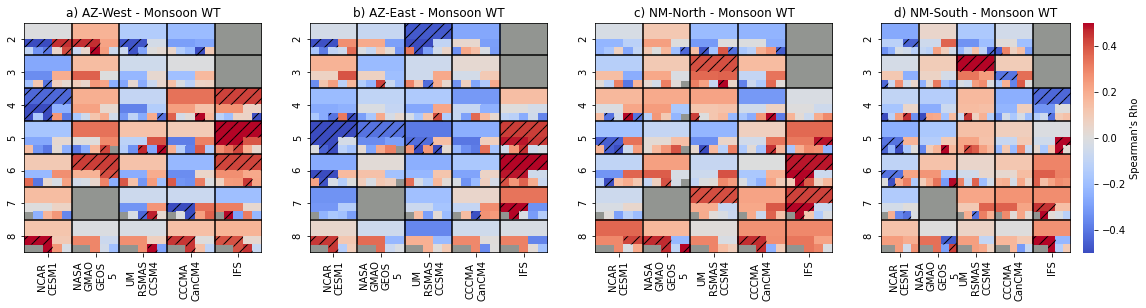

In [14]:
wt=0

fig = plt.figure(figsize=(16,4.5))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.03, right=0.98,
           bottom=0.20, top=0.91,
           wspace=0.20, hspace=0.20)
NMME_modelsBreak = [NMME_models[ii].replace('-','\n') for ii in range(len(NMME_models))]

for ba in range(len(SRegionNames)):
    ax = plt.subplot(gs1[0,ba])
    plt.title(rgsLableABC[ba]+') '+SRegionNames[ba]+' - '+WTname[wt]+' WT')
    if ba == 3:
        g = sns.heatmap(PearsonR_PR_FULL[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, 
                             cbar_kws={'label': "Spearman's Rho"})
    else:
        g = sns.heatmap(PearsonR_PR_FULL[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar=False)
    g.set_facecolor('xkcd:gray')
    # Show significance
    x= np.arange(len(NMME_modelsBreak)*5+1)
    y= np.arange(len(StartMonths)*4+1)
    zm = np.ma.masked_greater(PearsonR_PR_FULL[1,:,:,ba,wt], 0.10)
    plt.pcolor(x, y, zm, hatch='//', alpha=0.)
    
    # add grid that shows blocks of data
    for xx in range(6):
        ax.axvline(x=xx*5, c='k')
    for yy in range(8):
        ax.axhline(y=yy*4, c='k')

    ax.set_yticks(np.array(range(7))*4+2)
    ax.set_yticklabels(StartMonths)
    ax.set_xticks(np.array(range(5))*5+2.5)
    ax.set_xticklabels(NMME_modelsBreak, rotation = 90)

    
sPlotName= 'NMME_hindcast_PR_annomaly-corrections_WT-'+WTname[wt]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)                 

### WORK ON FIG. 3

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/2020041

        Plot map to: /glade/u/home/prein/projects/Arizona_WTing/plots/Fig03/Fig03.pdf


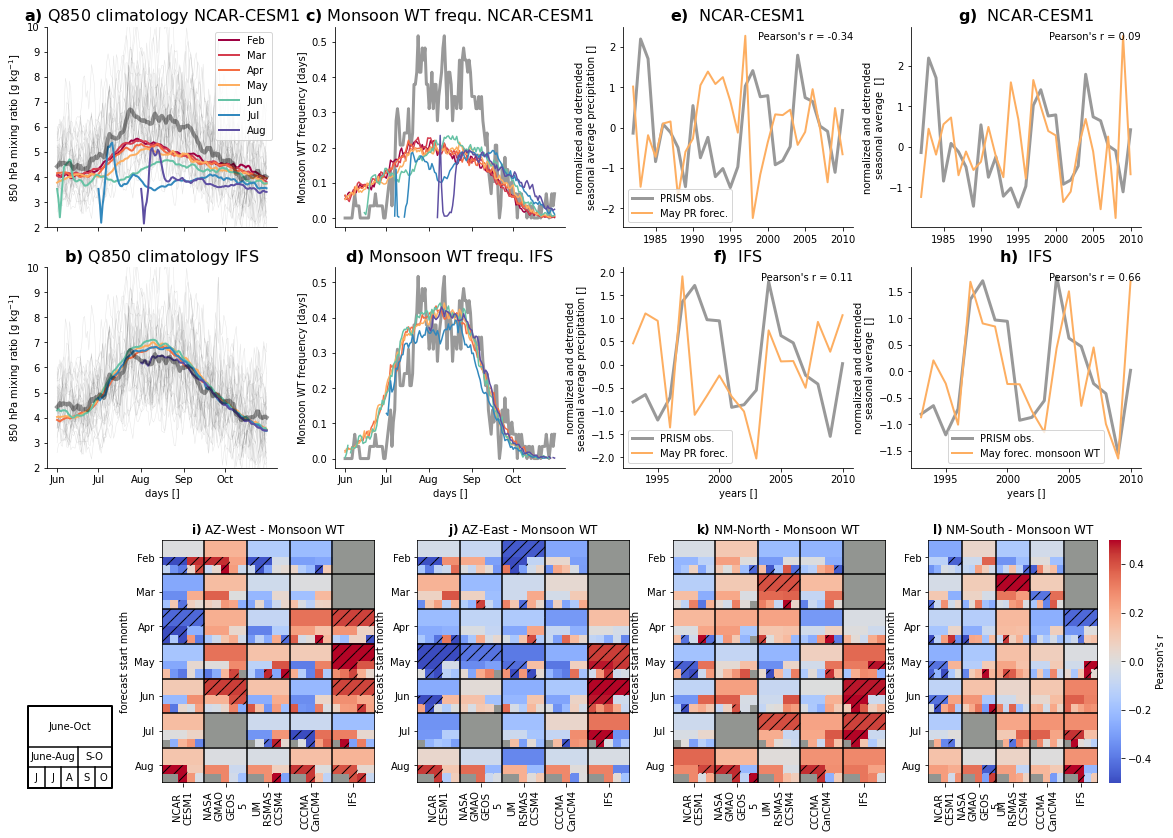

In [16]:
fig = plt.figure(figsize=(16,12.5))
rgsLableABC=list(string.ascii_lowercase)
Months = ['Jun','Jul','Aug','Sep','Oct']
MonthsFC = ['Feb','Mar','Apr', 'May','Jun','Jul','Aug','Sep','Oct']
iMonths = [0,30,61,92,122]

## ============================================================
## --- PLOT SEASONAL CYCLES OF Q850 ---
gs1 = gridspec.GridSpec(2,4) #rgiSize[2])
gs1.update(left=0.03, right=0.98,
           bottom=0.48, top=0.97,
           wspace=0.25, hspace=0.20)

ModSel = [0,4]
re = 0
ForecastCol = ['#9e0142','#d53e4f','#f46d43','#fdae61','#66c2a5','#3288bd','#5e4fa2']

for mod in range(len(ModSel)):
    mo = ModSel[mod]

    ax = plt.subplot(gs1[mod,0])

    for yy in range(EAR_Predictors.shape[0]):
        plt.plot(range(153), np.nanmean(EAR_Predictors[yy,:,0,re,:], axis=(1))*1000., c='k',lw=0.5, alpha=0.1)

    for mm in range(len(StartMonths)):
        plt.plot(range(153), np.nanmean(NAAM_Predictors[:,:,mo,re,mm,:], axis=(0,2,3))*1000., color=ForecastCol[mm], lw=2, label=rgsStartMonths[mm])

    plt.plot(range(153), np.nanmean(EAR_Predictors[:,:,0,re,:], axis=(0,2))*1000., c='k', lw=4, alpha=0.4)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylim(2, 10)
    plt.title(r"$\bf{" + str(rgsLableABC[mod])+ ")}$ "+'Q850 climatology '+NMME_models[ModSel[mod]], fontsize=16)
    if mod == 0:
        plt.legend()
    plt.ylabel("850 hPa mixing ratio [g kg$^{-1}$]")
    
    if mod == 1:
        ax.set_xticks(iMonths)
        ax.set_xticklabels(Months)
        plt.xlabel("days []")
    else:
        ax.set_xticks(iMonths)
        ax.set_xticklabels(['']*len(iMonths))

        
## ============================================================
## --- PLOT SEASONAL CYCLES OF MONSOON WT FREQUENCY ---
for mod in range(len(ModSel)):
    ax = plt.subplot(gs1[mod,1])
    mo = ModSel[mod]
    ax.plot(range(153), np.nanmean(ERA_WTs[:,:,0,re] == WTsort[ba][wt] , axis=1), c='k', lw=3, alpha=0.4)
    for mm in range(len(StartMonths)):
        iWTfr = np.array(NAAM_WTs[:,:,:,ba,mm,:] == WTsort[ba][wt])
        NAMM_WTact = np.nanmean(iWTfr, axis=(1,3))
        NAMM_WTact[NAMM_WTact == 0] = np.nan
        plt.plot(range(153), NAMM_WTact[:,mo], color=ForecastCol[mm]) #, label=NMME_models[mo])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylabel("Monsoon WT frequency [days]")
    if mod == 1:
        ax.set_xticks(iMonths)
        ax.set_xticklabels(Months)
        plt.xlabel("days []")
    else:
        ax.set_xticks(iMonths)
        ax.set_xticklabels(['']*len(iMonths))
    plt.title(r"$\bf{" + str(rgsLableABC[mod+2])+ ")}$ "+'Monsoon WT frequ. '+NMME_models[ModSel[mod]], fontsize=16)

    
## ============================================================
## --- PLOT SEASONAL PR VS MODELED PR ---
DATA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/PR/NMME_PR-forecasts_Monsoon-Basins.npz')
NAMM_PR = DATA['precipitation']
for mod in range(len(ModSel)):
    ax = plt.subplot(gs1[mod,2])
    Y_Fin = ~np.isnan(NAMM_PR[:,0,-1,ModSel[mod],0,ba])
    OBS = np.nanmean(NAMM_PR[:,:,3,ModSel[mod],:,ba], axis=(1,2))[Y_Fin]
    MOD = np.nanmean(PR_basins[:,:,0], axis=1)[Y_Fin]
    
    YYYY = rgiYY[Y_Fin]
    OBS = signal.detrend(OBS)
    OBS =(OBS-np.mean(OBS))/np.std(OBS)
    MOD = signal.detrend(MOD)
    MOD =(MOD-np.mean(MOD))/np.std(MOD)
    
    plt.plot(YYYY,MOD, c='k', lw=3, alpha=0.4, label='PRISM obs.')
    plt.plot(YYYY,OBS, color=ForecastCol[3], lw=2, label=rgsStartMonths[3]+' PR forec.')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylabel("normalized and detrended\nseasonal average precipitation []")
    if mod == 1:
        plt.xlabel("years []")
    plt.legend()
    plt.title(r"$\bf{" + str(rgsLableABC[mod+4])+ ")}$ "+' '+NMME_models[ModSel[mod]], fontsize=16)
    CorrCof = scipy.stats.pearsonr(MOD, OBS)
    plt.text(1, 0.95,'Pearson\'s r = '+str(np.round(CorrCof[0],2)),
         horizontalalignment='right',
         verticalalignment='center',
         transform = ax.transAxes)
    
## ============================================================
## --- PLOT SEASONAL PR VS MODELED WT FREQU. ---

for mod in range(len(ModSel)):
    ax = plt.subplot(gs1[mod,3])
    Y_Fin = ~np.isnan(NAMM_PR[:,0,-1,ModSel[mod],0,ba])
    
    OBS = np.nanmean(PR_basins[:,:,0], axis=1)[Y_Fin]
    MOD = Norma_WT_frequ[1,:,3,ModSel[mod],ba,WTsort[ba][wt]][Y_Fin]
        
    YYYY = rgiYY[Y_Fin]
    OBS = signal.detrend(OBS)
    OBS =(OBS-np.mean(OBS))/np.std(OBS)
    MOD = signal.detrend(MOD)
    MOD =(MOD-np.mean(MOD))/np.std(MOD)
    
    plt.plot(YYYY,OBS, c='k', lw=3, alpha=0.4, label='PRISM obs.')
    plt.plot(YYYY,MOD, color=ForecastCol[3], lw=2, label=rgsStartMonths[3]+' forec. monsoon WT')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylabel("normalized and detrended\nseasonal average  []")
    if mod == 1:
        plt.xlabel("years []")
    plt.title(r"$\bf{" + str(rgsLableABC[mod+6])+ ")}$ "+' '+NMME_models[ModSel[mod]], fontsize=16)
    CorrCof = scipy.stats.pearsonr(MOD, OBS)
    plt.text(1, 0.95,'Pearson\'s r = '+str(np.round(CorrCof[0],2)),
         horizontalalignment='right',
         verticalalignment='center',
         transform = ax.transAxes)
    if mod == 1:
        plt.legend()

    
    
## =====================================================
## --- PLOT THE HEATMAP OF CORRELATION COEFFICIENTS ---

#start with explanation of heat map
CbarAx = plt.axes([0.01, 0.12, 0.08, 0.1])
plt.axis('off')
plt.plot([0,5,5,0,0],[0,0,4,4,0], c='k', lw=2)
plt.plot([0,5],[2,2], c='k')
plt.text(2.5,3,'June-Oct',ha='center',va='center')
plt.plot([0,5],[1,1], c='k')
plt.plot([3,3],[1,2], c='k')
plt.text(1.5,1.5,'June-Aug',ha='center',va='center')
plt.text(4,1.5,'S-O',ha='center',va='center')

MM = ['J','J','A','S','O']
for mm in range(5):
    plt.plot([mm,mm],[0,1], c='k')
    plt.text(0.5+mm,0.5,MM[mm],ha='center',va='center')


wt=0
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.13, right=0.98,
           bottom=0.13, top=0.4,
           wspace=0.20, hspace=0.20)
NMME_modelsBreak = [NMME_models[ii].replace('-','\n') for ii in range(len(NMME_models))]


for ba in range(len(SRegionNames)):
    ax = plt.subplot(gs1[0,ba])
    plt.title(r"$\bf{" + str(rgsLableABC[ba+8])+ ")}$ "+SRegionNames[ba]+' - '+WTname[wt]+' WT')
    if ba == 3:
        g = sns.heatmap(PearsonR_PR_FULL[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, 
                             cbar_kws={'label': "Pearson's r"})
    else:
        g = sns.heatmap(PearsonR_PR_FULL[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar=False)
    g.set_facecolor('xkcd:gray')
    # Show significance
    x= np.arange(len(NMME_modelsBreak)*5+1)
    y= np.arange(len(StartMonths)*4+1)
    zm = np.ma.masked_greater(PearsonR_PR_FULL[1,:,:,ba,wt], 0.10)
    plt.pcolor(x, y, zm, hatch='//', alpha=0.)
    
    # add grid that shows blocks of data
    for xx in range(6):
        ax.axvline(x=xx*5, c='k')
    for yy in range(8):
        ax.axhline(y=yy*4, c='k')

    ax.set_yticks(np.array(range(7))*4+2)
    ax.set_yticklabels(StartMonths)
    ax.set_xticks(np.array(range(5))*5+2.5)
    ax.set_xticklabels(NMME_modelsBreak, rotation = 90)
    ax.set_yticklabels(MonthsFC, rotation = 0)
    plt.ylabel("forecast start month")

sPlotDir='/glade/u/home/prein/projects/Arizona_WTing/plots/Fig03/'
sPlotFile=sPlotDir
sPlotName= 'Fig03.pdf'   
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)                 

In [120]:
import seaborn as sns
from scipy import signal
# calculate correlation coefficiants
SpearmanR_PR = np.zeros((2,len(StartMonths),len(NMME_models),len(SRegionNames),3)); SpearmanR_PR[:]=np.nan
PearsonR_PR = np.copy(SpearmanR_PR)
Norma_WT_frequ_PR = np.zeros((2,len(rgiYY),len(StartMonths)+1,len(NMME_models),len(SRegionNames),3)); Norma_WT_frequ_PR[:]=np.nan

for ba in range(len(SRegionNames)): 
    for wt in range(3):
        for mod in range(len(NMME_models)):
            for mon in range(NAAM_WTs.shape[4]):
                MODEL = (NAAM_WTs[:,:,mod,ba,mon,:] == WTsort[ba][wt])*1.
                MODEL[np.isnan(NAAM_WTs[:,-1,mod,ba,mon,0]),:,:] = np.nan
                OBS = PR_basins[:,:,ba].T
                # Calculate monthly averages for WTs
                MODEL_MON = np.array([np.sum(MODEL[TimeMonsSeason.month == ii,:,:],axis=0) for ii in MONTHS])
                MODEL_MON = np.mean(MODEL_MON, axis=2)
                FIN_MM = np.array([1, 1, 1, 1, 1], dtype=bool) * ~np.isnan(MODEL_MON[:,-1])
                FIN_YY = ~np.isnan(NAAM_WTs[-1,:,mod,ba,mon,0])* ([False]*11+[True]*18)
                if (np.sum(FIN_MM) > 0) & (np.sum(FIN_YY) > 0):
                    # calculate seasonal averages
                    MODEL_MON = np.mean(MODEL_MON[FIN_MM,:], axis=0)
                    OBS = np.mean(OBS[FIN_MM,:], axis=0)
                    # Detrend the data
                    MODEL_DT = signal.detrend(MODEL_MON[FIN_YY])
                    OBS_DT = signal.detrend(OBS[FIN_YY])
                    SpearmanR_PR[:,mon,mod,ba,wt] = scipy.stats.spearmanr(MODEL_DT,OBS_DT)
                    PearsonR_PR[:,mon,mod,ba,wt] = scipy.stats.pearsonr(MODEL_DT,OBS_DT)
                    
                    # save the data for further analysis
                    Norma_WT_frequ_PR[0,FIN_YY,mon,mod,ba,wt] = OBS_DT
                    Norma_WT_frequ_PR[1,FIN_YY,mon,mod,ba,wt] = MODEL_DT

        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/NMME_hindcast_PR_annomaly-corrections_WT-Monsoon.pdf


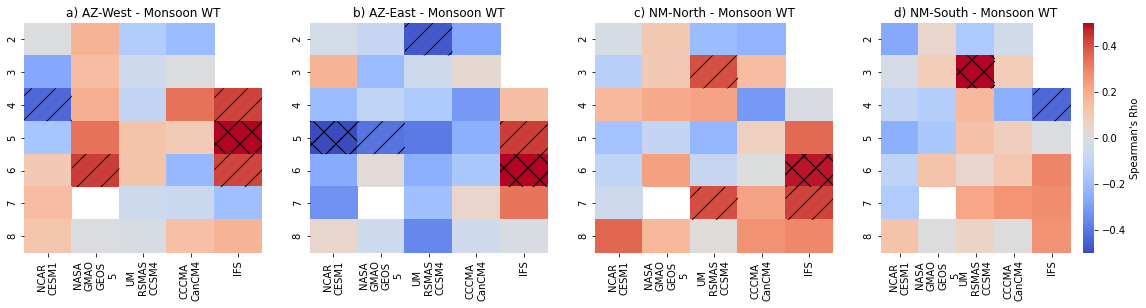

In [122]:
wt=0

fig = plt.figure(figsize=(16,4.5))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.03, right=0.98,
           bottom=0.20, top=0.91,
           wspace=0.20, hspace=0.20)
NMME_modelsBreak = [NMME_models[ii].replace('-','\n') for ii in range(len(NMME_models))]

for ba in range(len(SRegionNames)):
    ax = plt.subplot(gs1[0,ba])
    plt.title(rgsLableABC[ba]+') '+SRegionNames[ba]+' - '+WTname[wt]+' WT')
    if ba == 3:
        sns.heatmap(PearsonR_PR[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, 
                             cbar_kws={'label': "Spearman's Rho"})
    else:
        sns.heatmap(PearsonR_PR[0,:,:,ba,wt], cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar=False)
    # Show significance
    x= np.arange(len(NMME_modelsBreak)+1)
    y= np.arange(len(StartMonths)+1)
    zm = np.ma.masked_greater(PearsonR_PR[1,:,:,ba,wt], 0.05)
    plt.pcolor(x, y, zm, hatch='\/', alpha=0.)
    zm = np.ma.masked_greater(PearsonR_PR[1,:,:,ba,wt], 0.1)
    plt.pcolor(x, y, zm, hatch="/", alpha=0.)
    
    
    ax.set_yticklabels(StartMonths)
    ax.set_xticklabels(NMME_modelsBreak, rotation = 90)
    
sPlotName= 'NMME_hindcast_PR_annomaly-corrections_WT-'+WTname[wt]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)                 

(0.32785055952880165, 0.1841257540497299)

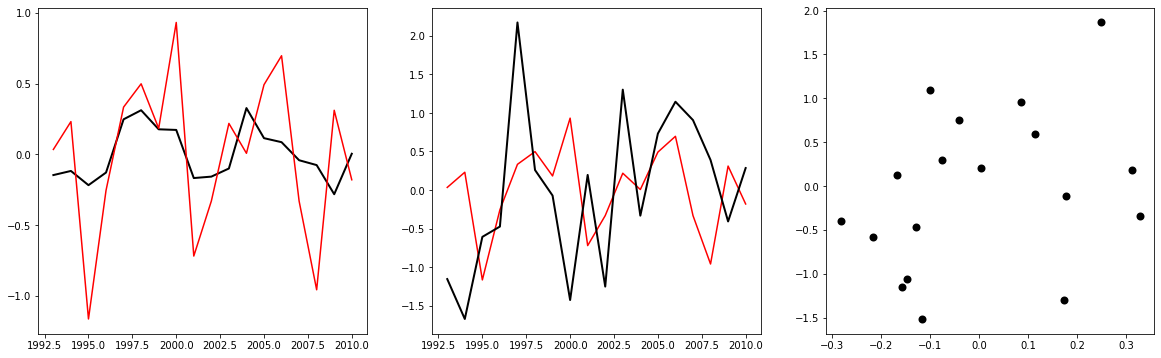

In [50]:
mm=3
mod = 4
ba=0
wt=0

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1, 3, 1)

plt.plot(rgiYY[:],Norma_WT_frequ_PR[0,:,mm,mod,ba,wt], c='k', lw=2)
plt.plot(rgiYY[:],Norma_WT_frequ_PR[1,:,mm,mod,ba,wt], c='r')

ax = fig.add_subplot(1, 3, 2)
plt.plot(rgiYY[:], Norma_WT_frequ_PR[1,:,mm,mod,ba,wt], c='r')
plt.plot(rgiYY[11:], norm(Norma_WT_frequ[0,11:,mm,mod,ba,wt]), c='k', lw=2)

ax = fig.add_subplot(1, 3, 3)
# plt.plot(rgiYY[:], Norma_WT_frequ_PR[1,:,mm,mod,ba,wt], c='r')
plt.scatter(Norma_WT_frequ_PR[0,:,mm,mod,ba,wt], norm(Norma_WT_frequ[0,:,mm,mod,ba,wt]), c='k', lw=2)

scipy.stats.pearsonr(Norma_WT_frequ_PR[0,11:,mm,mod,ba,wt], Norma_WT_frequ[0,11:,mm,mod,ba,wt])

### plot example of forcast performance

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


Text(0, 0.5, 'IFS normalized Monsoon day frequ.')

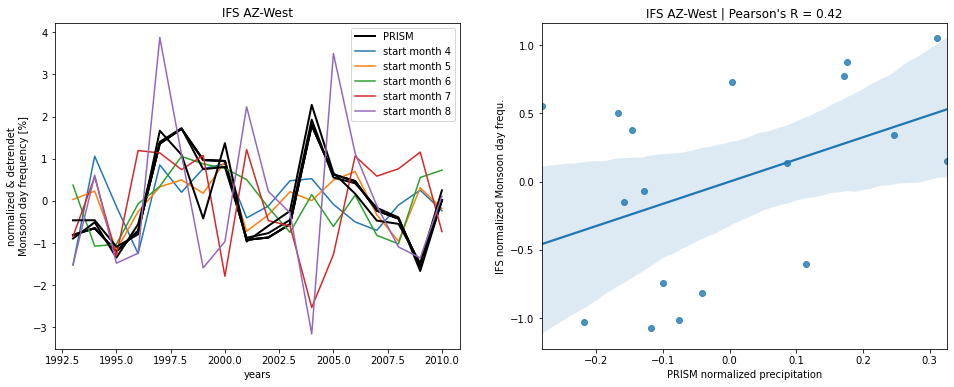

In [33]:
def norm(ARRAY):
    NORM = (ARRAY - np.nanmean(ARRAY))/np.std(ARRAY)
    return NORM

ba = 0
wt=0
mod=4
mo=4
Y_Fin = ~np.isnan(Norma_WT_frequ_PR[1,:,mo,mod,ba,wt])
M_Fin = ~np.isnan(Norma_WT_frequ_PR[0,-1,:,mod,ba,wt])

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1)

for mm in range(7):
    if mm == 0:
        LAB = 'PRISM'
    else:
        LAB = ''
    ax.plot(rgiYY[Y_Fin],norm(Norma_WT_frequ_PR[0,Y_Fin,mm,mod,ba,wt]), c='k', lw=2, label=LAB)
    if np.sum(~np.isnan(Norma_WT_frequ_PR[1,Y_Fin,mm,mod,ba,wt])) > 0:
        ax.plot(rgiYY[Y_Fin],Norma_WT_frequ_PR[1,Y_Fin,mm,mod,ba,wt], label='start month '+str(np.array(StartMonths)[mm]))
plt.xlabel('years')
plt.ylabel('normalized & detrendet\nMonsoon day frequency [%]')
plt.legend()
plt.title(NMME_models[mod]+' '+SRegionNames[ba])

# scatter plot
ax = fig.add_subplot(1, 2, 2)
ax = sns.regplot(x=Norma_WT_frequ_PR[0,Y_Fin,mo,mod,ba,wt],y=Norma_WT_frequ_PR[1,Y_Fin,mo,mod,ba,wt])
SR = np.round(scipy.stats.pearsonr(Norma_WT_frequ_PR[0,Y_Fin,mo,mod,ba,wt],Norma_WT_frequ_PR[1,Y_Fin,mo,mod,ba,wt])[0],2)
plt.title(NMME_models[mod]+' '+SRegionNames[ba]+" | Pearson's R = "+str(SR))
plt.xlabel('PRISM normalized precipitation')
plt.ylabel(NMME_models[mod]+' normalized Monsoon day frequ.')

### CORRELATION COEFFICIENT BETWEEN OBSERVED PR AND SEASONAL AVERAGE Q850

In [92]:
MODEL_MON[FIN_YY]

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.00549027, 0.00522756, 0.0053172 , 0.00533997,
       0.00554793, 0.00560982, 0.00537756, 0.00542384, 0.00526709,
       0.00526784, 0.0051052 , 0.00527703, 0.00521082, 0.00533954,
       0.00510823, 0.00504015, 0.00553368, 0.00540506])

In [90]:
MODEL_MON.shape

(5, 29)

In [128]:
MODEL_MON.shape

(5, 29)

In [125]:
FIN_YY

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [116]:
NAAM_Predictors.shape

(29, 153, 7, 4, 7, 1, 25)

In [131]:
import seaborn as sns
from scipy import signal
Norma_Pred_timeseries = np.zeros((len(rgiYY),len(StartMonths)+1,len(NMME_models),len(SRegionNames))); Norma_Pred_timeseries[:]=np.nan

SpearmanR_Pred = np.zeros((2,len(StartMonths),len(NMME_models),len(SRegionNames))); SpearmanR_Pred[:]=np.nan
PearsonR_Pred = np.copy(SpearmanR_Pred)

Norma_WT_frequ_Pred = np.zeros((2,len(rgiYY),len(StartMonths)+1,len(NMME_models),len(SRegionNames))); Norma_WT_frequ_PR[:]=np.nan

for ba in range(len(SRegionNames)): 
    for mod in range(len(NMME_models)):
        for mon in range(NAAM_WTs.shape[4]):
            MODEL = NAAM_Predictors[:,:,mod,ba,mon,0,:]
            OBS = PR_basins[:,:,ba].T
            # Calculate monthly averages for WTs
            MODEL_MON = np.array([np.mean(MODEL[:,TimeMonsSeason.month == ii,:],axis=1) for ii in MONTHS])
            MODEL_MON = np.nanmean(MODEL_MON, axis=2)
            FIN_MM = ~np.isnan(MODEL_MON[:,-1])
            FIN_YY = ~np.isnan(MODEL_MON[-1,:])
            if (np.sum(FIN_MM) > 0) & (np.sum(FIN_YY) > 0):
                # calculate seasonal averages
                MODEL_MON = np.mean(MODEL_MON[FIN_MM,:], axis=0)
                OBS = np.mean(OBS[FIN_MM,:], axis=0)
                # Detrend the data
                MODEL_DT = signal.detrend(MODEL_MON[FIN_YY])
                OBS_DT = signal.detrend(OBS[FIN_YY])
                SpearmanR_Pred[:,mon,mod,ba] = scipy.stats.spearmanr(MODEL_DT,OBS_DT)
                PearsonR_Pred[:,mon,mod,ba] = scipy.stats.pearsonr(MODEL_DT,OBS_DT)

                # save the data for further analysis
                Norma_WT_frequ_Pred[0,FIN_YY,mon,mod,ba] = OBS_DT
                Norma_WT_frequ_Pred[1,FIN_YY,mon,mod,ba] = MODEL_DT




# for ba in range(len(SRegionNames)): 
#     for mo in range(len(NMME_models)):
#         Y_Fin = ~np.isnan(NAAM_Predictors[:,0,mo,ba,-1,0,0])
#         iEN_Fin = np.sum(~np.isnan(NAAM_Predictors[-1,0,mo,ba,-1,0,:]) == True)
#         iM_Fin = np.sum(~np.isnan(NAAM_Predictors[-1,0,mo,ba,:,0,0]) == False)
#         Heatmap = np.mean(NAAM_Predictors[:,:,mo,ba,:,:,:iEN_Fin], axis=(1,3,4))
#         Heatmap = np.append(Heatmap[:,:], np.mean(EAR_Predictors[:,:,0,ba],axis=(1,2))[:,None], axis=1)
#         # normalize the heatmap
#         HeatmapNorm = (Heatmap - np.nanmean(Heatmap, axis=0)[None,:])/np.nanstd(Heatmap, axis=0)[None,:]
#         Norma_Pred_timeseries[Y_Fin,iM_Fin:,mo,ba] = signal.detrend(HeatmapNorm[Y_Fin,iM_Fin:], axis=0)

            
# # calculate correlation coefficiants
# SpearmanR_Pred = np.zeros((2,len(StartMonths),len(NMME_models),len(SRegionNames))); SpearmanR_Pred[:]=np.nan
# PearsonR_Pred = np.copy(SpearmanR_Pred)
# for ba in range(len(SRegionNames)): 
#     for mod in range(len(NMME_models)):
#         for mo in range(len(StartMonths)):
#             Y_Fin = ~np.isnan(Norma_Pred_timeseries[:,mo,mod,ba])
#             try:
#                 SpearmanR_Pred[:,mo,mod,ba] = scipy.stats.spearmanr(Norma_Pred_timeseries[Y_Fin,mo,mod,ba],signal.detrend(PR_basins[Y_Fin,re]))
#                 PearsonR_Pred[:,mo,mod,ba] = scipy.stats.pearsonr(Norma_Pred_timeseries[Y_Fin,mo,mod,ba],signal.detrend(PR_basins[Y_Fin,re]))
#             except:
#                 continue

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/NMME_hindcast_PR_annomaly-corrections_norm-Pred.pdf


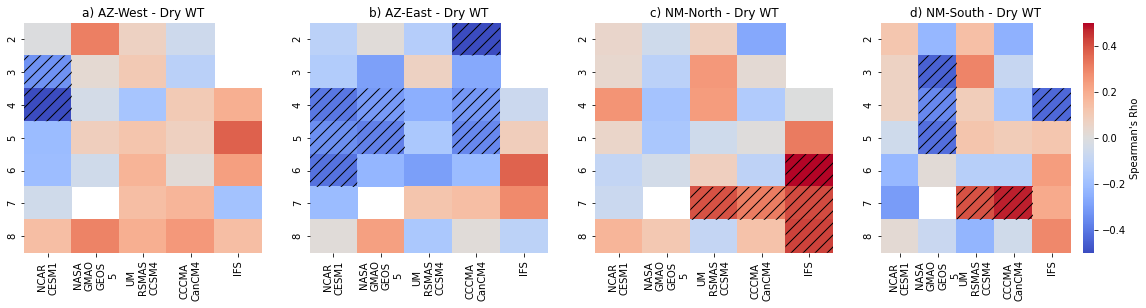

In [132]:
fig = plt.figure(figsize=(16,4.5))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.03, right=0.98,
           bottom=0.20, top=0.91,
           wspace=0.20, hspace=0.20)
NMME_modelsBreak = [NMME_models[ii].replace('-','\n') for ii in range(len(NMME_models))]

for ba in range(len(SRegionNames)):
    ax = plt.subplot(gs1[0,ba])
    plt.title(rgsLableABC[ba]+') '+SRegionNames[ba]+' - '+WTname[wt]+' WT')
    if ba == 3:
        sns.heatmap(SpearmanR_Pred[0,:,:,ba], cmap='coolwarm', vmin=-0.5, vmax=0.5, 
                             cbar_kws={'label': "Spearman's Rho"})
    else:
        sns.heatmap(SpearmanR_Pred[0,:,:,ba], cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar=False)
    # Show significance
    x= np.arange(len(NMME_modelsBreak)+1)
    y= np.arange(len(StartMonths)+1)
    zm = np.ma.masked_greater(SpearmanR_Pred[1,:,:,ba], 0.1)
    plt.pcolor(x, y, zm, hatch='//', alpha=0.)
    
    
    ax.set_yticklabels(StartMonths)
    ax.set_xticklabels(NMME_modelsBreak, rotation = 90)
    
sPlotName= 'NMME_hindcast_PR_annomaly-corrections_norm-Pred.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)                 

## CORRELATION OF OBSERVED AND SIMULATED PRECIPITATION ANNOMALIES

In [32]:
### load the forecasted precipitation
# this data comes from: projects/Arizona_WTing/programs/NMME_PR_prediction/NMME_PR_prediction.ipynb
DATA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/PR/NMME_PR-forecasts_Monsoon-Basins.npz')
NAMM_PR = DATA['precipitation']
print(DATA['precip_dims'])

year,month,start-month,model,ensemble-member,basin


In [70]:
HeatmapNorm.shape

(29, 6)

In [78]:
import seaborn as sns
from scipy import signal
Norma_Pred_timeseries = np.zeros((len(rgiYY),len(StartMonths)+1,len(NMME_models),len(SRegionNames))); Norma_Pred_timeseries[:]=np.nan
for ba in range(len(SRegionNames)): 
    for mo in range(len(NMME_models)):
        Y_Fin = ~np.isnan(NAMM_PR[:,0,-1,mo,0,ba])
        iEN_Fin = np.sum(~np.isnan(NAMM_PR[-1,0,-1,mo,:,ba]) == True)
        iM_Fin = np.sum(~np.isnan(NAMM_PR[-1,0,-1,:,0,ba]) == False)
        Heatmap = np.mean(NAMM_PR[:,:,:,mo,:iEN_Fin,ba], axis=(1,3))
        Heatmap = np.append(Heatmap[:,:], PR_basins[:,ba][:,None], axis=1)
        # normalize the heatmap
        HeatmapNorm = (Heatmap - np.nanmean(Heatmap, axis=0)[None,:])/np.nanstd(Heatmap, axis=0)[None,:]
        for mm in range(6):
            Y_Fin = ~np.isnan(HeatmapNorm[:,mm])
            try:
                if sum(Y_Fin) > 15:
                    Norma_Pred_timeseries[Y_Fin,mm,mo,ba] = signal.detrend(HeatmapNorm[Y_Fin,mm], axis=0)
            except:
                continue
        
#         try:
#             Norma_Pred_timeseries[Y_Fin,iM_Fin:,mo,ba] = signal.detrend(HeatmapNorm[Y_Fin,iM_Fin:], axis=0)
#         except:
#             continue

            
# calculate correlation coefficiants
SpearmanR_Pred = np.zeros((2,len(StartMonths),len(NMME_models),len(SRegionNames))); SpearmanR_Pred[:]=np.nan
PearsonR_Pred = np.copy(SpearmanR_Pred)
for ba in range(len(SRegionNames)): 
    for mod in range(len(NMME_models)):
        for mo in range(len(StartMonths)):
            Y_Fin = ~np.isnan(Norma_Pred_timeseries[:,mo,mod,ba])
            try:
                SpearmanR_Pred[:,mo,mod,ba] = scipy.stats.spearmanr(Norma_Pred_timeseries[Y_Fin,mo,mod,ba],signal.detrend(PR_basins[Y_Fin,re]))
                PearsonR_Pred[:,mo,mod,ba] = scipy.stats.pearsonr(Norma_Pred_timeseries[Y_Fin,mo,mod,ba],signal.detrend(PR_basins[Y_Fin,re]))
            except:
                continue

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


        Plot map to: /glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/NMME_hindcast_PR_annomaly-corrections_PR-forecast.pdf


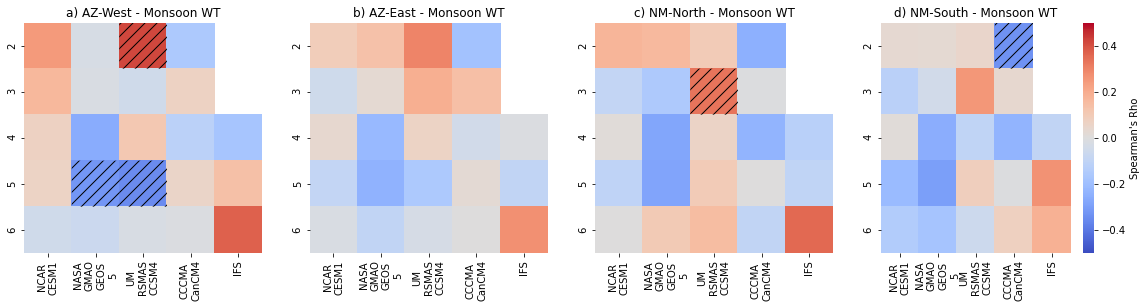

In [79]:
fig = plt.figure(figsize=(16,4.5))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.03, right=0.98,
           bottom=0.20, top=0.91,
           wspace=0.20, hspace=0.20)
NMME_modelsBreak = [NMME_models[ii].replace('-','\n') for ii in range(len(NMME_models))]

for ba in range(len(SRegionNames)):
    ax = plt.subplot(gs1[0,ba])
    plt.title(rgsLableABC[ba]+') '+SRegionNames[ba]+' - '+WTname[wt]+' WT')
    if ba == 3:
        sns.heatmap(SpearmanR_Pred[0,:,:,ba], cmap='coolwarm', vmin=-0.5, vmax=0.5, 
                             cbar_kws={'label': "Spearman's Rho"})
    else:
        sns.heatmap(SpearmanR_Pred[0,:,:,ba], cmap='coolwarm', vmin=-0.5, vmax=0.5, cbar=False)
    # Show significance
    x= np.arange(len(NMME_modelsBreak)+1)
    y= np.arange(len(StartMonths)+1)
    zm = np.ma.masked_greater(SpearmanR_Pred[1,:,:,ba], 0.1)
    plt.pcolor(x, y, zm, hatch='//', alpha=0.)
    
    
    ax.set_yticklabels(StartMonths)
    ax.set_xticklabels(NMME_modelsBreak, rotation = 90)
    
sPlotName= 'NMME_hindcast_PR_annomaly-corrections_PR-forecast.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)                 

In [85]:
NAMM_PR.shape
year,month,start-month,model,ensemble-member,basin

(29, 5, 5, 5, 25, 4)

In [88]:
PR_NAMM_act.shape

(29, 5, 25)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


Text(0.5, 1.0, 'IFS AZ-West')

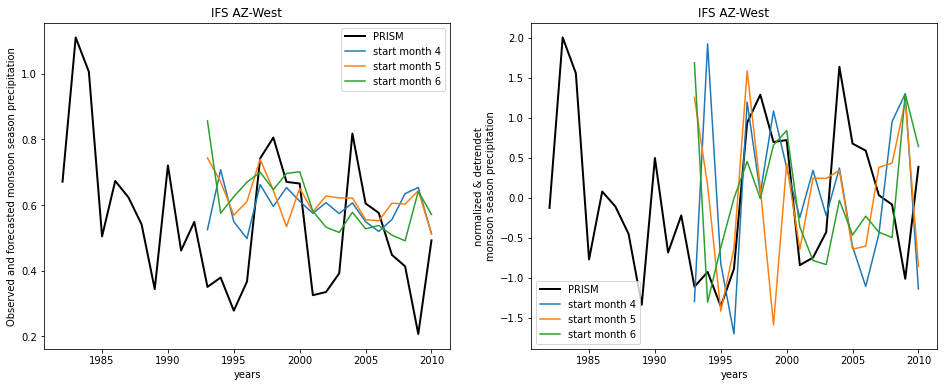

In [91]:
##### example pr time series

ba = 0
mod=4
mo=4

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 2, 1)
PR_NAMM_act = np.nanmean(NAMM_PR[:,:,:,mod,:,ba], axis=(1,3))

ax.plot(rgiYY,PR_basins[:,ba], c='k', lw=2, label='PRISM')
for mm in range(5):
    if np.sum(~np.isnan(PR_NAMM_act[:,mm])) > 0:
        ax.plot(rgiYY[:],PR_NAMM_act[:,mm]*1000, label='start month '+str(np.array(StartMonths)[mm]))
plt.xlabel('years')
plt.ylabel('Observed and forecasted monsoon season precipitation')
plt.legend()
plt.title(NMME_models[mod]+' '+SRegionNames[ba])


ax = fig.add_subplot(1, 2, 2)
ax.plot(rgiYY,Norma_Pred_timeseries[:,-1,mod,ba], c='k', lw=2, label='PRISM')
for mm in range(5):
    if np.sum(~np.isnan(Norma_Pred_timeseries[:,mm,mod,ba])) > 0:
        ax.plot(rgiYY[:],Norma_Pred_timeseries[:,mm,mod,ba], label='start month '+str(np.array(StartMonths)[mm]))
plt.xlabel('years')
plt.ylabel('normalized & detrendet\nmonsoon season precipitation')
plt.legend()
plt.title(NMME_models[mod]+' '+SRegionNames[ba])

# # scatter plot
# ax = fig.add_subplot(1, 2, 2)
# ax = sns.regplot(x=Norma_WT_frequ_PR[Y_Fin,-1,mod,ba,wt],y=Norma_WT_frequ_PR[Y_Fin,mo,mod,ba,wt])
# SR = np.round(scipy.stats.spearmanr(Norma_WT_frequ_PR[Y_Fin,-1,mod,ba,wt],Norma_WT_frequ_PR[Y_Fin,mo,mod,ba,wt])[0],2)
# plt.title(NMME_models[mod]+' '+SRegionNames[ba]+" | Spearman's Rho = "+str(SR))
# plt.xlabel('PRISM normalized precipitation')
# plt.ylabel(NMME_models[mod]+' normalized Monsoon day frequ.')